# Movie Recommendation System



## 1. Introduction

The aim of the project is to develop a movie recommendation system using 3 types of personalized recommenders:

* Knowledge-based filtering - users can filter specific characteristics of items
* Content Based Filtering - they suggest similar items based on a particular item. (Genres in this case)
* Collaborative Filtering - the system matches items with similar atributes and provides recommendation based on this matches

And 2 non-personalized recommender:

* Most-Popular: the one that recommends the most popular items
* Best-Rated: the one that recommends the items who was rated with higher grades

## 2. Importing libraries and datasets

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

C:\Users\Marcela\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# import datasets
df_movies = pd.read_csv('dataset/movies.csv', sep=',')
df_ratings = pd.read_csv('dataset/ratings.csv', sep =',')
#df_tags = pd.read_csv('dataset/tags.csv', sep =',')

In [3]:
df_movies.head()
df_ratings.head()
#df_tags.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


## 3. Exploratory Data Analysis

#### Movies dataframe

In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
df_movies['genres'].value_counts().head(10)

Drama                   1053
Comedy                   946
Comedy|Drama             435
Comedy|Romance           363
Drama|Romance            349
Documentary              339
Comedy|Drama|Romance     276
Drama|Thriller           168
Horror                   167
Horror|Thriller          135
Name: genres, dtype: int64

In [7]:
print('Shape of movie dataset: ',df_movies.shape)

Shape of movie dataset:  (9742, 3)


In [8]:
df_movies['title'].nunique()

9737

We have 9742 movies, no null values. 5 titles are repeated and this can be different versions.

#### Ratings dataframe

In [9]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [11]:
print('Minimum ratings on 1 movie: ',df_ratings['movieId'].value_counts().min())

Minimum ratings on 1 movie:  1


In [12]:
n_users = len(df_ratings['userId'].unique())
n_movies = len(df_ratings['movieId'].unique())
n_ratings = len(df_ratings['rating'])

In [13]:
sparsity = 1 - (n_ratings)/float(n_users * n_movies)

In [14]:
print("N° of users:", n_users)
print("N° of movies:", n_movies)
print("N° of ratings:", n_ratings)
print("Data sparsity:", sparsity)

N° of users: 610
N° of movies: 9724
N° of ratings: 100836
Data sparsity: 0.9830003169443864


The rating between users and movies(items) is very sparse, therefore it becomes more difficult to identify similar users

## 4. Preprocessing data

#### Film genre analysis

In [15]:
df_movies_modif = df_movies

In [16]:
df_movies_modif['genres'] = df_movies['genres'].str.split('|')

In [17]:
genres_list = ['movieId','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
               'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War',
               'Western','IMAX','(no genres listed)']

In [18]:
movie_list = {
    'movieId':0,
    'Action':0,
    'Adventure':0,
    'Animation':0,
    'Children':0,
    'Comedy':0,
    'Crime':0,
    'Documentary':0,
    'Drama':0,
    'Fantasy':0,
    'Film-Noir':0,
    'Horror':0,
    'Musical':0,
    'Mystery':0,
    'Romance':0,
    'Sci-Fi':0,
    'Thriller':0,
    'War':0,
    'Western':0,
    'IMAX':0,
    '(no genres listed)':0
}

In [19]:
genres_matrix = pd.DataFrame(columns =genres_list)

In [20]:
def zerar_lista():
    movie_list = {
    'movieId':0,
    'Action':0,
    'Adventure':0,
    'Animation':0,
    'Children':0,
    'Comedy':0,
    'Crime':0,
    'Documentary':0,
    'Drama':0,
    'Fantasy':0,
    'Film-Noir':0,
    'Horror':0,
    'Musical':0,
    'Mystery':0,
    'Romance':0,
    'Sci-Fi':0,
    'Thriller':0,
    'War':0,
    'Western':0,
    'IMAX':0,
    '(no genres listed)':0
    }
    return movie_list

In [21]:
for index in range(df_movies_modif['genres'].shape[0]):
    for nb_genres in range(len(df_movies_modif['genres'][index])):
        movie_list['movieId'] = df_movies_modif['movieId'][index]
        for item in genres_list:
            if df_movies_modif['genres'][index][nb_genres] == item:
                movie_list[item] = 1
                
    genres_matrix.loc[index] = movie_list
    movie_list = zerar_lista()

genres_matrix

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculation of the sum of the number of films by genre:

In [22]:
total = []
for genres in genres_list:
    total.append(genres_matrix[genres].sum())

genres_matrix.loc[len(genres_matrix)] = dict(zip(genres_list, total))

In [23]:
genres_matrix

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,193583,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9741,193609,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
total_genres = dict(zip(genres_list, total))
total_genres.pop("movieId")

411115845

In [25]:
total_genres

{'Action': 1828,
 'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Crime': 1199,
 'Documentary': 440,
 'Drama': 4361,
 'Fantasy': 779,
 'Film-Noir': 87,
 'Horror': 978,
 'Musical': 334,
 'Mystery': 573,
 'Romance': 1596,
 'Sci-Fi': 980,
 'Thriller': 1894,
 'War': 382,
 'Western': 167,
 'IMAX': 158,
 '(no genres listed)': 34}

In [26]:
df_total_genres = pd.DataFrame(list(total_genres.items()), columns=['Genres', 'Total'])
df_total_genres

,Genres,Total
0,Action,1828
1,Adventure,1263
2,Animation,611
3,Children,664
4,Comedy,3756
5,Crime,1199
6,Documentary,440
7,Drama,4361
8,Fantasy,779
9,Film-Noir,87


#### Separating year

In [27]:
df_movies_modif

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [28]:
df_movies_modif['year'] = int()

In [29]:
for movie in range(df_movies_modif['movieId'].shape[0]):
    try:
        df_movies_modif['year'][movie] = int(df_movies_modif['title'][movie][-6:].replace(')','').replace(' ','').replace('(',''))
    except:    
       df_movies_modif['year'][movie] = 0
        
df_movies_modif

<ipython-input-29-fc598522dbe6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_modif['year'][movie] = int(df_movies_modif['title'][movie][-6:].replace(')','').replace(' ','').replace('(',''))
<ipython-input-29-fc598522dbe6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_modif['year'][movie] = 0


,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018


In [30]:
df_movies_modif['year'].unique()

array([1995, 1994, 1996, 1976, 1992, 1967, 1993, 1964, 1977, 1965, 1982,
       1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970, 1955, 1959,
       1968, 1988, 1997, 1972, 1943, 1952, 1951, 1957, 1961, 1958, 1954,
       1934, 1944, 1960, 1963, 1942, 1941, 1953, 1939, 1950, 1946, 1945,
       1938, 1947, 1935, 1936, 1956, 1949, 1932, 1975, 1974, 1971, 1979,
       1987, 1986, 1980, 1978, 1985, 1966, 1962, 1983, 1984, 1948, 1933,
       1931, 1922, 1998, 1929, 1930, 1927, 1928, 1999, 2000, 1926, 1919,
       1921, 1925, 1923, 2001, 2002, 2003, 1920, 1915, 1924, 2004, 1916,
       1917, 2005, 2006, 1902,    0, 1903, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 1908], dtype=int64)

In [31]:
df_movies_modif[df_movies_modif['year']==0]

,movieId,title,genres,year
6059,40697,Babylon 5,[Sci-Fi],0
9031,140956,Ready Player One,"[Action, Sci-Fi, Thriller]",0
9091,143410,Hyena Road,[(no genres listed)],0
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,[(no genres listed)],0
9179,149334,Nocturnal Animals,"[Drama, Thriller]",0
9259,156605,Paterson,[(no genres listed)],0
9367,162414,Moonlight,[Drama],0
9448,167570,The OA,[(no genres listed)],0
9514,171495,Cosmos,[(no genres listed)],0
9515,171631,Maria Bamford: Old Baby,[(no genres listed)],0


As there are few data without the year of release and most don't have the genre, we will delete those.

In [32]:
df_movies_release = df_movies_modif[df_movies_modif['year']!=0]

Convert year from int to object. 

In [64]:
df_movies_release['year'] = df_movies_release['year'].astype('object')
df_movies_release.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9729 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9729 non-null   int64 
 1   title    9729 non-null   object
 2   genres   9729 non-null   object
 3   year     9729 non-null   object
dtypes: int64(1), object(3)
memory usage: 380.0+ KB


<ipython-input-64-9cfbced8855c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_release['year'] = df_movies_release['year'].astype('object')


In [65]:
df_movies_release

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint (2017),[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018


## 5. Data Visualization

#### User watched movies

In [34]:
movies_by_user = df_ratings.groupby('userId')['movieId'].apply(list)

In [35]:
user_historic = {}
for userId in df_ratings['userId'].unique():
    user_historic[userId] = len(movies_by_user[userId])

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Amount of Movies watched by user\n')

Text(0.5, 0, 'Users')

Text(0, 0.5, 'Amount of movies')

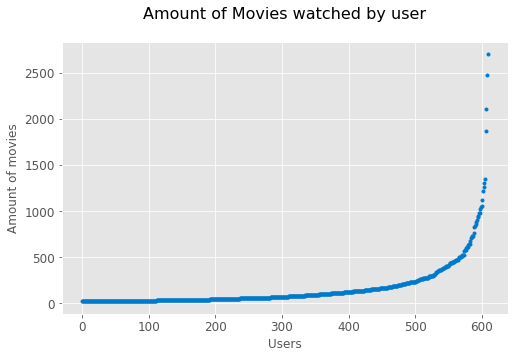

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(sorted(list(user_historic.values())), ".", color ='#007acc')
plt.title('Amount of Movies watched by user\n', fontsize=16)
plt.xlabel('Users')
plt.ylabel('Amount of movies')

In [37]:
print('Mean: ',np.mean(list(user_historic.values())))
print('Max: ',np.max(list(user_historic.values())))
print('Min: ',np.min(list(user_historic.values())))
print('Median: ',np.median(list(user_historic.values())))
print('Std: ',np.std(list(user_historic.values())))

Mean:  165.30491803278687
Max:  2698
Min:  20
Median:  70.5
Std:  269.2596080610495


Most users watched few movies, we have a very high standard deviation.

#### Popularity

In [38]:
popularity = df_ratings.groupby('movieId')['userId'].apply(list)

In [39]:
movie_popularity = {}
for movieId in df_ratings['movieId'].unique():
    movie_popularity[movieId] = len(popularity[movieId][:])

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Popularity\n')

Text(0.5, 0, 'Movies')

Text(0, 0.5, 'Amount of users')

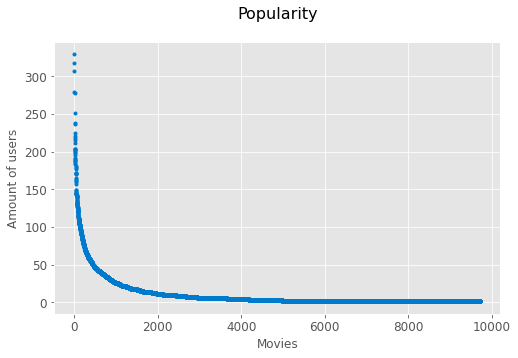

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(sorted(list(movie_popularity.values()))[::-1] , '.', color ='#007acc')
plt.title('Popularity\n', fontsize=16)
plt.xlabel('Movies')
plt.ylabel('Amount of users')

In [41]:
print('Mean: ',np.mean(list(movie_popularity.values())))
print('Max: ',np.max(list(movie_popularity.values())))
print('Min: ',np.min(list(movie_popularity.values())))
print('Median: ',np.median(list(movie_popularity.values())))
print('Std: ',np.std(list(movie_popularity.values())))

Mean:  10.369806663924312
Max:  329
Min:  1
Median:  3.0
Std:  22.399852938941176


Most of the films were poorly evaluated by users.

#### Number of films by genre

In [42]:
sorted_genres = df_total_genres.sort_values(by=['Total'],ascending=True)

<Figure size 720x432 with 0 Axes>

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Number of films by genre\n')

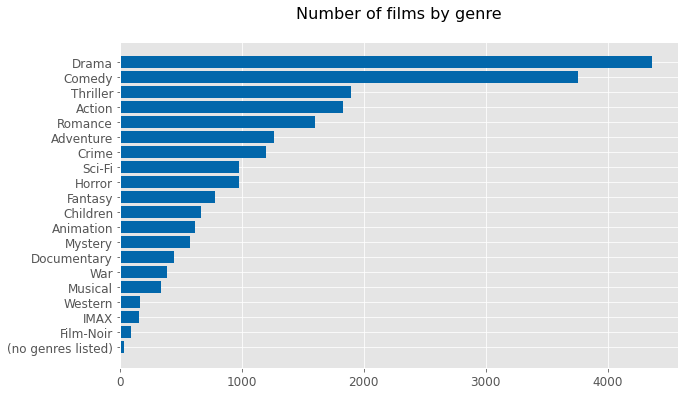

In [43]:
plt.figure(figsize=(10, 6))
plt.barh(sorted_genres['Genres'],sorted_genres['Total'], color ='#0267ab')
plt.title('Number of films by genre\n', fontsize=16)

Drama was the most watched genre with more than 4000 titles, followed by comedy. Thriller and Action are very close to each other.

#### Ratings

<Figure size 576x360 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x182d3a33c40>,
 'caps': [<matplotlib.lines.Line2D at 0x182d38c3340>,
 'boxes': [<matplotlib.lines.Line2D at 0x182d3a338e0>],
 'medians': [<matplotlib.lines.Line2D at 0x182d38c3a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x182d38c3d60>],
 'means': []}

Text(0.5, 1.0, 'Ratings\n')

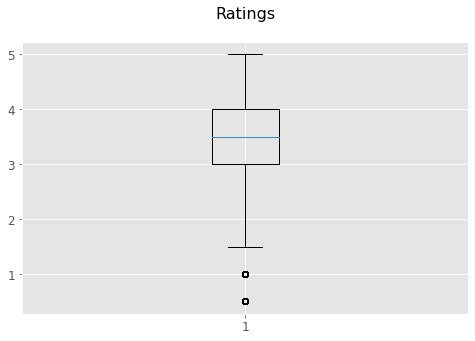

In [44]:
plt.figure(figsize=(8, 5))
plt.boxplot(df_ratings['rating'])
plt.title('Ratings\n', fontsize=16)

<Figure size 576x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Histogram of ratings each movie receives\n')

Text(0.5, 0, 'Ratings')

Text(0, 0.5, 'Frequency')

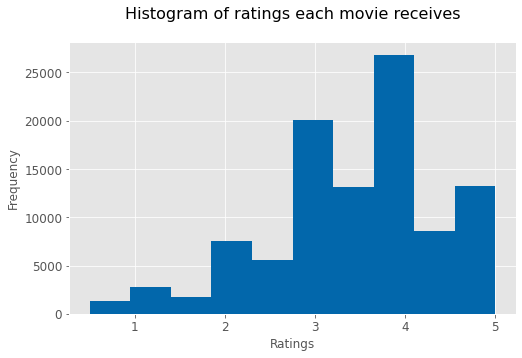

In [45]:
plt.figure(figsize=(8, 5))
df_ratings['rating'].hist(color ='#0267ab')
plt.title('Histogram of ratings each movie receives\n', fontsize=16)
plt.xlabel('Ratings')
plt.ylabel('Frequency')

We have some outliers, but considering that there are few ratings we will accept and it makes sense to have this variations since we are analyzing movies.

#### Year of release

<Figure size 576x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Number of movies released per year\n')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Amount of movies')

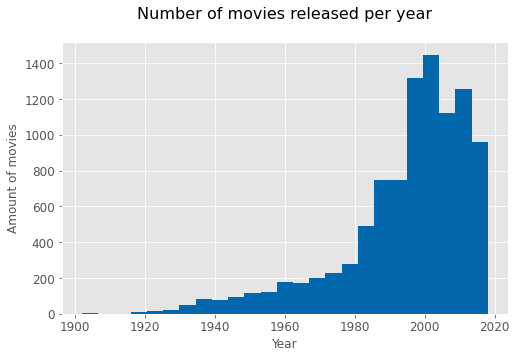

In [66]:
plt.figure(figsize=(8, 5))
df_movies_release['year'].hist(color ='#0267ab', bins=25)
plt.title('Number of movies released per year\n', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Amount of movies')

In [67]:
df_movies_release['year'].describe()

count     9729
unique     106
top       2002
freq       311
Name: year, dtype: int64

The year with the most releases was 2002 with 311 films. As expected, more films were released over the years.